In [1]:
import numpy as np
import tensorflow as tf
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.utils import shuffle
from scipy import stats
from scipy import optimize
import joblib
import matplotlib.pyplot as plt

#working directory (needed for saving models)
filepath_wd = ".../Resultate_final/working_directory/"
#directory for results
filepath = ".../Resultate_final/PTF/saved_single_run/"

In [2]:
#Market and option parameters as in section 4.2 of 'Assessing Asset-Liability Risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
s_0 = 100
r = 0.01
corr= 0.3
tau = 1/52
T = 1/3
K = 100

mu = np.empty(20)
sigma = np.empty(20)
for i in range(0,10):
    mu[i] = mu[i+10] = (3+(i+1)/2)/100
    sigma[i] = sigma[i+10] = (15+(i+1))/100

cov_mat = np.empty((20,20))
for i in range(0,20):
    for j in range(0,20):
        if i != j:
            cov_mat[i,j] = corr
        else:
            cov_mat[i,j] = 1

C = np.linalg.cholesky(cov_mat)

#Confidence levels for Value-at-Risk and Expected Shortfall
alpha_VaR = 0.995
alpha_ES = 0.99

In [3]:
#Sizes for training set, validation set, test set, and set size for Monte Carlo estimation of the risk measures
M_1 = 1500000
M_2 = 500000
M_3 = 500000
#ignore N or N_2 in the following. Was kept just in case, but not used.
N_2 = 1
M_MC = 500000
#size of the set of data points used to calculate an IS density
M_IS = 1000000
#quantile for which the IS density will be computed
alpha_IS = 0.995

In [4]:
#Function for calculating simulated values of S_tau and simulated payoffs P_T from simulations of multivariate standard normal random variables
def data_gen(M,N,Z,V):
    #correlating the independent components
    Z = np.transpose(np.matmul(C,np.transpose(Z)))
    V = np.transpose(np.matmul(C,np.transpose(V)))
    
    #simulate S_tau under P
    S_tau_pre = np.empty((M, 20))
    for j in range(0,20):
        S_tau_pre[:,j] = s_0 * np.exp( (mu[j]-0.5*sigma[j]**2)*tau + np.sqrt(tau)*sigma[j]*Z[:,j] )
    S_tau = np.tile(S_tau_pre, (N,1))

    #simulate S_T given S_tau under Q
    S_T = np.empty((N*M,20))
    for j in range(0,20):
        S_T[:,j] = S_tau[:,j] * np.exp( (r-0.5*sigma[j]**2)*(T-tau) + np.sqrt(T-tau)*sigma[j]*V[:,j] )

    #compute discounted option payoffs
    P_T_pre =np.empty((len(S_T), 20))
    for j in range(0,10):
        P_T_pre[:,j] = np.exp(-r*(T-tau)) * np.maximum(S_T[:,j]-K,0)
    for j in range(10,20):
        P_T_pre[:,j] = np.exp(-r*(T-tau)) * np.maximum(K-S_T[:,j],0)
    P_T = np.sum(P_T_pre, axis=1)
    return S_tau,P_T

#the function DT(Z,\theta)
def data_trans_IS(Z,IS):
    res = np.empty((len(Z),20))
    for j in range(20):
        res[:,j] = Z[:,j]*np.sqrt(IS[20+j]) + IS[j]
    return res

#The density function of Z
def f(y):
    return stats.multivariate_normal.pdf(y, mean=np.full(20,0), cov=np.identity(20))

#The density function of Z_\theta (note that x is interpreted as theta, needed for the least-squares solver to work properly)
def f_theta(y, x):
    return stats.multivariate_normal.pdf(y, mean=x[0:20], cov=np.diag(x[20:40]), allow_singular=True)

#This function describes the approximation of the expression inside the sum of m_2(theta)
def g_q_alpha_hat_reweighted(x,L,q_alpha_hat):
    return np.sqrt(f(y=L[:,0:20])/f_theta(y=L[:,0:20],x=x))*(L[:,-1]>q_alpha_hat)

#bounds for the IS density parameters (for the parameters corresponding to the mean no bounds are necessary, the standard deviation parameters however needs to be non-negative)
bnds_lower = np.empty((40))
bnds_upper = np.empty((40))
for j in range(20):
    bnds_lower[j] = -np.inf
    bnds_upper[j] = np.inf
    bnds_lower[20+j] = 0
    bnds_upper[20+j] = np.inf
    
bnds = (bnds_lower, bnds_upper)

In [5]:
#Generating realisations of multivariate standard normal random variables
Z_IS = np.random.multivariate_normal(mean=np.full(20,0), cov=np.identity(20), size=M_IS)
V_IS = np.random.multivariate_normal(mean=np.full(20,0), cov=np.identity(20), size=M_IS)

#Calculate the risk factor S_tau and the corresponding simulated payoffs P_T
S_tau_IS, P_T_IS = data_gen(M=M_IS, N=1, Z=Z_IS, V=V_IS)

#define and compile neural network model, setup as in 'Assessing Asset-Liability Risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
bi_IS = np.log( np.sum(P_T_IS)/len(P_T_IS))
model_IS = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(20,)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(1, activation='exponential', bias_initializer=tf.keras.initializers.Constant(value=bi_IS))])
model_IS.compile(loss='mse', optimizer='adam', metrics=['mse'])
model_IS.fit(x=S_tau_IS, y=P_T_IS, epochs=100, batch_size=10000, verbose=0)

#Calculate realisations of L_hat from the training data set using the trained neural network
L_hat_IS = np.column_stack((Z_IS, model_IS.predict(S_tau_IS)[:,0]))
L_hat_IS_sort = L_hat_IS[L_hat_IS[:,-1].argsort()[::-1]]

#Calculating the corresponding estimator for Value-at-Risk in order to approximate g
q_alpha_hat_IS = L_hat_IS_sort[int(M_IS*(1-alpha_IS)-1), -1]
print('q_alpha_hat_IS_NN:',q_alpha_hat_IS)

#Calculating the (hopefully) approximately optimal \theta^*_{NN} by minimising m_2 using the approximated g
IS_NN = optimize.least_squares(g_q_alpha_hat_reweighted, x0=np.concatenate((np.full(20,0),np.full(20,1))), args=(L_hat_IS, q_alpha_hat_IS), bounds=bnds).x

#define and train a random forest according to the optimal parameters from tuning
rfr_IS = RandomForestRegressor(n_estimators=160, criterion='squared_error', max_features=8, min_samples_leaf=70, bootstrap=True, verbose=0, n_jobs=-1)
rfr_IS.fit(X=S_tau_IS, y=P_T_IS)

#Calculate realisations of L_hat from the training data set using the trained random forest
L_hat_IS = np.column_stack((Z_IS, rfr_IS.predict(S_tau_IS)))
L_hat_IS_sort = L_hat_IS[L_hat_IS[:,-1].argsort()[::-1]]

#Calculating the corresponding estimator for Value-at-Risk in order to approximate g
q_alpha_hat_IS = L_hat_IS_sort[int(M_IS*(1-alpha_IS)-1), -1]
print('q_alpha_hat_IS_RF:',q_alpha_hat_IS)

#Calculating the (hopefully) approximately optimal \theta^*_{RF} by minimising m_2 using the approximated g
IS_RF = optimize.least_squares(g_q_alpha_hat_reweighted, x0=np.concatenate((np.full(20,0),np.full(20,1))), args=(L_hat_IS, q_alpha_hat_IS), bounds=bnds).x

#print IS density parameters for checking
print(IS_NN)
print(IS_RF)

2021-10-25 21:38:02.513565: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2021-10-25 21:38:04.575082: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30988 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:15:00.0, compute capability: 7.0
2021-10-25 21:38:04.576729: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30988 MB memory:  -> device: 1, name: Tesla V100-SXM2-32GB, pci bus id: 0000:16:00.0, compute capability: 7.0
2021-10-25 21:38:04.578250: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1510] Created device /job:localhost/replica:0/task:

q_alpha_hat_IS_NN: 110.7425537109375
q_alpha_hat_IS_RF: 107.4944000231792
[ 1.14885643  0.96090254  0.74917424  0.59228099  0.54079809  0.56506569
  0.60914037  0.59250598  0.50213888  0.28595462 -0.50617917 -0.40150599
 -0.58238158 -0.44558021 -0.521803   -0.48549069 -0.46918057 -0.26869345
 -0.54152565 -0.5090359   1.01549139  0.92643983  1.00059196  0.99740233
  1.01480537  0.9699812   0.98347207  1.00616627  1.0139353   1.05437246
  0.9828731   0.95442559  0.96659414  0.94619972  0.97526894  0.99885024
  1.04299264  0.94531254  0.97291426  0.99910746]
[ 0.70424195  0.58879319  0.47488493  0.41665695  0.30356229  0.2887358
  0.34508054  0.42044866  0.37843419  0.40613239 -0.28882743 -0.26339665
 -0.34777876 -0.25818488 -0.26069003 -0.26446742 -0.23117013 -0.25605214
 -0.29069422 -0.25054626  1.65984721  1.50478967  1.14050089  1.07938699
  1.13451111  1.10107083  1.22218444  0.92984975  1.04419604  0.98807522
  0.97595227  1.00020867  1.06380057  0.97212577  0.97693342  0.99088331
 

In [6]:
#Generating simulations for multivariate standard normal random variables for training set, validation set, test set, set for Monte Carlo estimation of risk measures
Z_train = np.random.multivariate_normal(mean=np.full(20,0), cov=np.identity(20), size=M_1)
V_train = np.random.multivariate_normal(mean=np.full(20,0), cov=np.identity(20), size=M_1)
Z_val = np.random.multivariate_normal(mean=np.full(20,0), cov=np.identity(20), size=M_2)
V_val = np.random.multivariate_normal(mean=np.full(20,0), cov=np.identity(20), size=M_2)
Z_test = np.random.multivariate_normal(mean=np.full(20,0), cov=np.identity(20), size=M_3)
V_test = np.random.multivariate_normal(mean=np.full(20,0), cov=np.identity(20), size=M_3)
Z_MC = np.random.multivariate_normal(mean=np.full(20,0), cov=np.identity(20), size=M_MC)
V_MC = np.random.multivariate_normal(mean=np.full(20,0), cov=np.identity(20), size=M_MC)

#calculate DT(Z,\theta^*_{NN})
Z_train_NN = data_trans_IS(Z_train,IS_NN)
Z_val_NN = data_trans_IS(Z_val,IS_NN)
Z_test_NN = data_trans_IS(Z_test,IS_NN)
Z_MC_NN = data_trans_IS(Z_MC,IS_NN)
#calculating the risk factors under the IS distribution and corresponding option prices
S_tau_train_NN, P_T_train_NN = data_gen(M=M_1,N=1,Z=Z_train_NN, V=V_train)
S_tau_val_NN, P_T_val_NN = data_gen(M=M_2,N=1,Z=Z_val_NN, V=V_val)
S_tau_test_NN, P_T_test_NN = data_gen(M=M_3,N=1,Z=Z_test_NN, V=V_test)
S_tau_MC_NN, P_T_MC_NN = data_gen(M=M_MC,N=1,Z=Z_MC_NN, V=V_MC)

#calculate DT(Z,\theta^*_{RF})
Z_train_RF = data_trans_IS(Z_train,IS_RF)
Z_val_RF = data_trans_IS(Z_val,IS_RF)
Z_test_RF = data_trans_IS(Z_test,IS_RF)
Z_MC_RF = data_trans_IS(Z_MC,IS_RF)
#calculating the risk factors under the IS distribution and corresponding option prices
S_tau_train_RF, P_T_train_RF = data_gen(M=M_1,N=1,Z=Z_train_RF, V=V_train)
S_tau_val_RF, P_T_val_RF = data_gen(M=M_2,N=1,Z=Z_val_RF, V=V_val)
S_tau_test_RF, P_T_test_RF = data_gen(M=M_3,N=1,Z=Z_test_RF, V=V_test)
S_tau_MC_RF, P_T_MC_RF = data_gen(M=M_MC,N=1,Z=Z_MC_RF, V=V_MC)

In [7]:
#calculating parameters for the sets B_1 and B_2
s_20_1 = s_0 * np.exp((mu[0:3]-0.5*sigma[0:3]**2)*tau + sigma[0:3]*np.sqrt(tau)*stats.norm.ppf(0.2, loc=0, scale=1))
s_80_1 = s_0 * np.exp((mu[9:12]-0.5*sigma[9:12]**2)*tau + sigma[9:12]*np.sqrt(tau)*stats.norm.ppf(0.8, loc=0, scale=1))
s_20_2 = s_0 * np.exp((mu[9:12]-0.5*sigma[9:12]**2)*tau + sigma[9:12]*np.sqrt(tau)*stats.norm.ppf(0.2, loc=0, scale=1))
s_80_2 = s_0 * np.exp((mu[0:3]-0.5*sigma[0:3]**2)*tau + sigma[0:3]*np.sqrt(tau)*stats.norm.ppf(0.8, loc=0, scale=1))

#calculate the indices of the set B_1 and B_2 for the test set created with the IS density calculated by the neural network
B_1_NN = np.apply_along_axis(np.all, axis=1, arr=np.column_stack( (np.apply_along_axis(np.all, axis=1, arr=S_tau_test_NN[:,0:3] > s_20_1), np.apply_along_axis(np.all, axis=1, arr=S_tau_test_NN[:,9:12] < s_80_1)) ) )
B_2_NN = np.apply_along_axis(np.all, axis=1, arr=np.column_stack( (np.apply_along_axis(np.all, axis=1, arr=S_tau_test_NN[:,0:3] < s_80_2), np.apply_along_axis(np.all, axis=1, arr=S_tau_test_NN[:,9:12] > s_20_2)) ) )

#calculate the indices of the set B_1 and B_2 for the test set created with the IS density calculated by the random forest
B_1_RF = np.apply_along_axis(np.all, axis=1, arr=np.column_stack( (np.apply_along_axis(np.all, axis=1, arr=S_tau_test_RF[:,0:3] > s_20_1), np.apply_along_axis(np.all, axis=1, arr=S_tau_test_RF[:,9:12] < s_80_1)) ) )
B_2_RF = np.apply_along_axis(np.all, axis=1, arr=np.column_stack( (np.apply_along_axis(np.all, axis=1, arr=S_tau_test_RF[:,0:3] < s_80_2), np.apply_along_axis(np.all, axis=1, arr=S_tau_test_RF[:,9:12] > s_20_2)) ) )

In [8]:
#define and compile neural network model, setup as in section 4.2 of 'Assessing Asset-Liability Risk with Neural Networks' (Cheridito, Ery, Wüthrich 2020)
bi = np.log( np.sum(P_T_train_NN)/len(P_T_train_NN))
model = tf.keras.models.Sequential([
    tf.keras.layers.BatchNormalization(input_shape=(20,)),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(20, activation='tanh'),
    tf.keras.layers.Dense(1, activation='exponential', bias_initializer=tf.keras.initializers.Constant(value=bi))])
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
#function for saving models after each epoch for later evaluation
checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath_wd + "PTF_IS_2_saved_epoch_{epoch:01d}.hdf5", monitor='loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')
#training the neural network
hist = model.fit(x=S_tau_train_NN, y=P_T_train_NN, epochs=100, batch_size=10000, validation_data=(S_tau_val_NN,P_T_val_NN), callbacks=[checkpoints])

#loading the saved models after every epoch
models_eval = []
for i in range(1,101):
    models_eval.append(tf.keras.models.load_model(filepath_wd + "PTF_IS_2_saved_epoch_" + str(i) + ".hdf5"))
    
#computation of the metrics (a), (b), (c) with B_1 and (c) with B_2
metric_a_NN = []
metric_b_NN = []
metric_c_B_1_NN = []
metric_c_B_2_NN = []
metric_c_B_1_NN = []
metric_c_B_2_NN = []
mse_train_NN = hist.history['mse'][-1]
mse_val_NN = hist.history['val_mse'][-1]

for j in range(100):
    P_T_pred_tmp = models_eval[j].predict(S_tau_test_NN)[:,0]
    mc_tmp = P_T_pred_tmp - P_T_test_NN
    metric_a_NN.append(np.sum(mc_tmp)/len(P_T_test_NN))
    metric_b_NN.append(np.sum((mc_tmp)*P_T_pred_tmp)/len(P_T_test_NN))
    metric_c_B_1_NN.append(np.sum(mc_tmp[B_1_NN])/len(P_T_test_NN))
    metric_c_B_2_NN.append(np.sum(mc_tmp[B_2_NN])/len(P_T_test_NN))

VaR_hat_NN = []
ES_hat_NN = []

#computation of option price depending on the risk factor S_tau according to the models, i.e. computation of L_hat_i's
L_hat_NN = model.predict(S_tau_MC_NN)[:,0]
L_hat_c_NN = np.column_stack((Z_MC_NN, L_hat_NN))

#calculation of risk measures in a stepwise procedure
#number of steps
step_number = 200
#step size
i = 500000/step_number

for n in range(1, step_number+1):
    #use first k simulations of L_hat
    k = int(n*i)
    
    #calculation of the IS estimators for Value-at-Risk and Expected Shortfall
    L_hat_c_sort_NN = L_hat_c_NN[L_hat_c_NN[0:k,-1].argsort()[::-1]]
    w = f(L_hat_c_sort_NN[:,0:20])/(k*f_theta(x=IS_NN, y=L_hat_c_sort_NN[:,0:20]))

    j_VaR = 0
    w_sum_tmp = 0
    while (w_sum_tmp <= (1-alpha_VaR) and j_VaR<k):
        w_sum_tmp += w[j_VaR]
        j_VaR += 1
    VaR_hat_NN.append(L_hat_c_sort_NN[j_VaR,-1])
    
    j_ES = 0
    w_sum_tmp = 0
    while (w_sum_tmp <= (1-alpha_ES) and j_ES<k):
        w_sum_tmp += w[j_ES]
        j_ES += 1
    ES_hat_NN.append((1/(1-alpha_ES)) * np.sum(w[0:j_ES-1]*L_hat_c_sort_NN[0:j_ES-1,-1]) + ( 1 - (1 / (1-alpha_ES)) * np.sum(w[0:j_ES-1]) )*L_hat_c_sort_NN[j_ES,-1])

Epoch 1/100
150/150 [==============================] - 1s 3ms/step - loss: 2834.1506 - mse: 2834.1506 - val_loss: 3023.9287 - val_mse: 3023.9287
Epoch 2/100
150/150 [==============================] - 0s 2ms/step - loss: 1683.9025 - mse: 1683.9025 - val_loss: 1861.6536 - val_mse: 1861.6536
Epoch 3/100
150/150 [==============================] - 0s 2ms/step - loss: 1628.9677 - mse: 1628.9677 - val_loss: 1612.7321 - val_mse: 1612.7321
Epoch 4/100
150/150 [==============================] - 0s 2ms/step - loss: 1603.3940 - mse: 1603.3940 - val_loss: 1585.7640 - val_mse: 1585.7640
Epoch 5/100
150/150 [==============================] - 0s 2ms/step - loss: 1589.7133 - mse: 1589.7133 - val_loss: 1575.3607 - val_mse: 1575.3607
Epoch 6/100
150/150 [==============================] - 0s 2ms/step - loss: 1582.0032 - mse: 1582.0032 - val_loss: 1569.1813 - val_mse: 1569.1813
Epoch 7/100
150/150 [==============================] - 0s 2ms/step - loss: 1577.2325 - mse: 1577.2325 - val_loss: 1565.3177 - val_

In [9]:
#perform a grid search in order to find the (approximately) best hyperparameters min_samples_leaf and max_features
#values that will be checked
max_features_list = [4,6,8]
min_samples_leaf_list = [20,30,40,50]
opt_param = np.full(2,0)
opt_score = np.inf

for max_features in max_features_list:
    for min_samples_leaf in min_samples_leaf_list:
        rfr_tuning = RandomForestRegressor(n_estimators=160, max_features=max_features, min_samples_leaf=min_samples_leaf, bootstrap=True, criterion='squared_error', verbose=0, n_jobs=-1)
        rfr_tuning.fit(X=S_tau_train_RF, y=P_T_train_RF)
        score = mean_squared_error(y_true=P_T_val_RF, y_pred=rfr_tuning.predict(S_tau_val_RF))
        print('min_samples_leaf: ', min_samples_leaf, ', MSE: ', score)
        if score < opt_score:
            opt_param_RF = np.array([max_features,min_samples_leaf])
            opt_score = score
            print('New best!')

print('Best parameters found in grid search: ', opt_param_RF, ' with MSE ', opt_score)

min_samples_leaf:  20 , MSE:  1399.6331062671911
New best!
min_samples_leaf:  30 , MSE:  1399.55039844917
New best!
min_samples_leaf:  40 , MSE:  1399.3230851448368
New best!
min_samples_leaf:  50 , MSE:  1399.6867492994324
min_samples_leaf:  20 , MSE:  1399.4545669900676
min_samples_leaf:  30 , MSE:  1399.0468372523715
New best!
min_samples_leaf:  40 , MSE:  1399.0547725382796
min_samples_leaf:  50 , MSE:  1399.1729831658618
min_samples_leaf:  20 , MSE:  1399.9968074354906
min_samples_leaf:  30 , MSE:  1399.1081652130633
min_samples_leaf:  40 , MSE:  1399.0642834294588
min_samples_leaf:  50 , MSE:  1399.07839640099
Best parameters found in grid search:  [ 6 30]  with MSE  1399.0468372523715


In [10]:
#trees will be added to the random forest consecutively in these steps, i.e. steps of 40
n_tree_steps = []
for i in range(40,1001,40):
    n_tree_steps.append(int(i))

mse_train_RF = []
mse_val_RF = []
metric_a_RF= []
metric_b_RF = []
metric_c_B_1_RF = []
metric_c_B_2_RF = []
metric_c_B_1_RF = []
metric_c_B_2_RF = []

#definition of the random forest with optimal parameters from the tuning procedure
rfr = RandomForestRegressor(n_estimators=0, criterion='squared_error', max_features=opt_param_RF[0], min_samples_leaf=int(opt_param_RF[1]), bootstrap=True, verbose=0, warm_start=True, n_jobs=-1)

#training of the random forest by consecutively adding trees according to n_tree_steps and computation of metrics after each such step
for n in n_tree_steps:
    rfr.n_estimators = n
    rfr.fit(X=S_tau_train_RF, y=P_T_train_RF)
    
    mse_train_RF.append(mean_squared_error(y_true=P_T_train_RF, y_pred=rfr.predict(S_tau_train_RF)))
    mse_val_RF.append(mean_squared_error(y_true=P_T_val_RF, y_pred=rfr.predict(S_tau_val_RF)))
    
    P_T_pred_tmp = rfr.predict(S_tau_test_RF)
    mc_tmp = P_T_pred_tmp - P_T_test_RF
    metric_a_RF.append(np.sum(mc_tmp)/len(P_T_test_RF))
    metric_b_RF.append(np.sum((mc_tmp)*P_T_pred_tmp)/len(P_T_test_RF))
    metric_c_B_1_RF.append(np.sum(mc_tmp[B_1_RF])/len(P_T_test_RF))
    metric_c_B_2_RF.append(np.sum(mc_tmp[B_2_RF])/len(P_T_test_RF))
    print(n,'of',n_tree_steps[-1],'trees built')

VaR_hat_RF = []
ES_hat_RF = []

#computation of option price depending on the risk factor S_tau according to the models, i.e. computation of L_hat_i's
L_hat_RF = rfr.predict(S_tau_MC_RF)
L_hat_c_RF = np.column_stack((Z_MC_RF, L_hat_RF))

#calculation of risk measures in a stepwise procedure
#number of steps
step_number = 200
i = 500000/step_number

for n in range(1, step_number+1):
    #use first k simulations of L_hat
    k = int(n*i)
    
    #calculation of the IS estimators for Value-at-Risk and Expected Shortfall
    L_hat_c_sort_RF = L_hat_c_RF[L_hat_c_RF[0:k,-1].argsort()[::-1]]
    w = f(L_hat_c_sort_RF[:,0:20])/(k*f_theta(x=IS_RF, y=L_hat_c_sort_RF[:,0:20]))

    j_VaR = 0
    w_sum_tmp = 0
    while (w_sum_tmp <= (1-alpha_VaR) and j_VaR<k):
        w_sum_tmp += w[j_VaR]
        j_VaR += 1
    VaR_hat_RF.append(L_hat_c_sort_RF[j_VaR,-1])
    
    j_ES = 0
    w_sum_tmp = 0
    while (w_sum_tmp <= (1-alpha_ES) and j_ES<k):
        w_sum_tmp += w[j_ES]
        j_ES += 1
    ES_hat_RF.append((1/(1-alpha_ES)) * np.sum(w[0:j_ES-1]*L_hat_c_sort_RF[0:j_ES-1,-1]) + ( 1 - (1 / (1-alpha_ES)) * np.sum(w[0:j_ES-1]) )*L_hat_c_sort_RF[j_ES,-1])

40 of 1000 trees built
80 of 1000 trees built
120 of 1000 trees built
160 of 1000 trees built
200 of 1000 trees built
240 of 1000 trees built
280 of 1000 trees built
320 of 1000 trees built
360 of 1000 trees built
400 of 1000 trees built
440 of 1000 trees built
480 of 1000 trees built
520 of 1000 trees built
560 of 1000 trees built
600 of 1000 trees built
640 of 1000 trees built
680 of 1000 trees built
720 of 1000 trees built
760 of 1000 trees built
800 of 1000 trees built
840 of 1000 trees built
880 of 1000 trees built
920 of 1000 trees built
960 of 1000 trees built
1000 of 1000 trees built


Plots of metrics and training/validation MSE of the random forest and neural network with evolving training processes, i.e. on the $x$-axes we find either the number of trees added or the number of epochs completed.

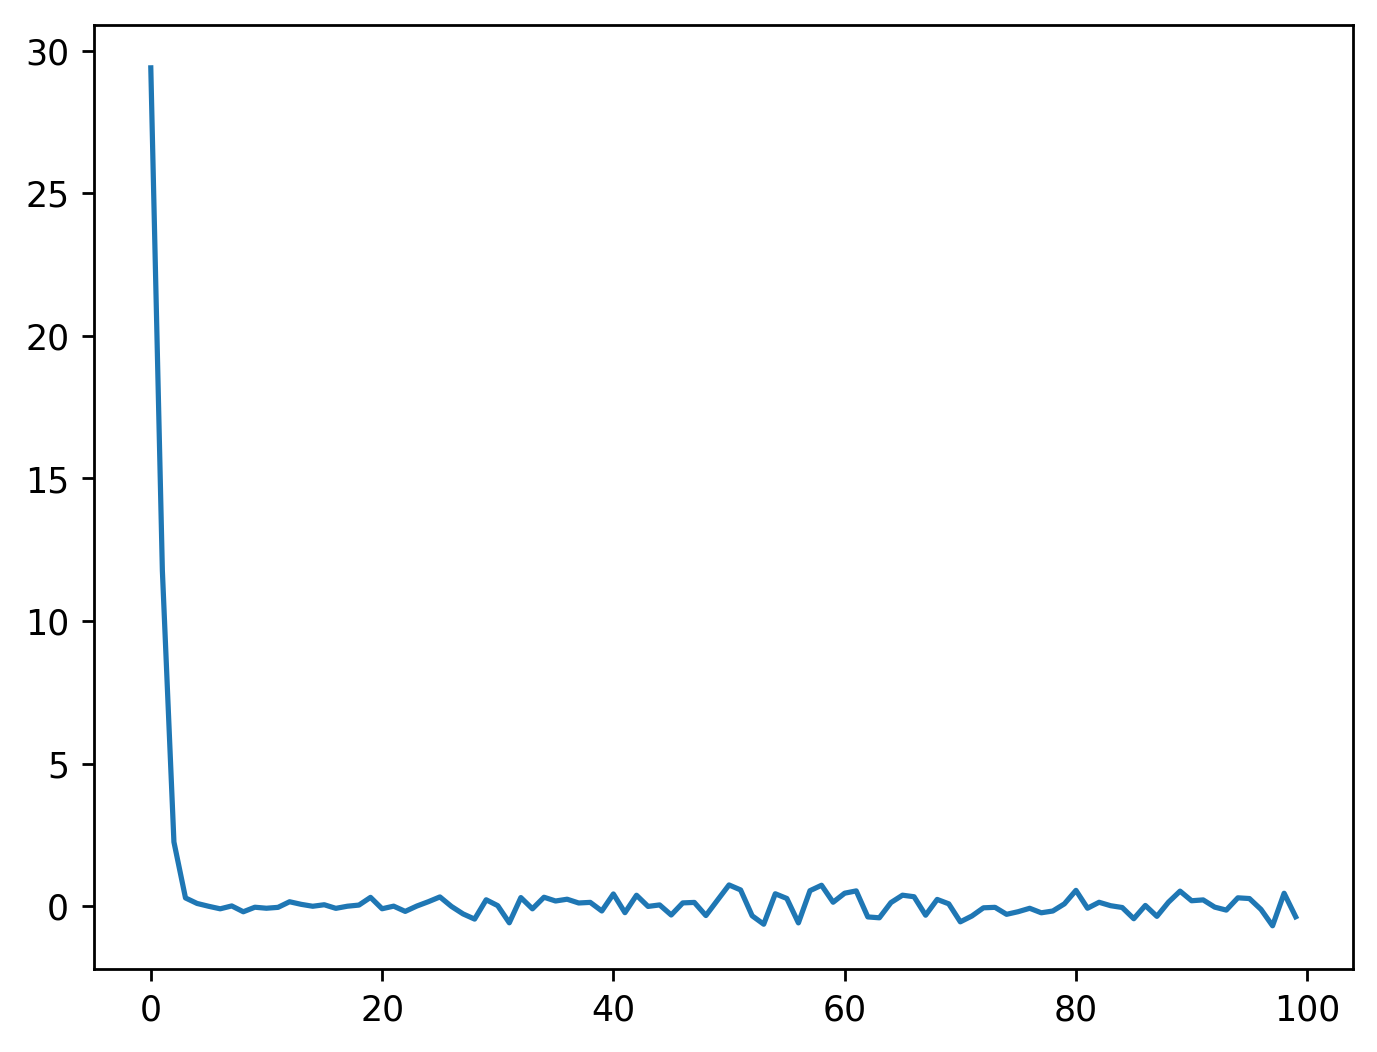

In [11]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(100),metric_a_NN, color='tab:blue')
plt.show()

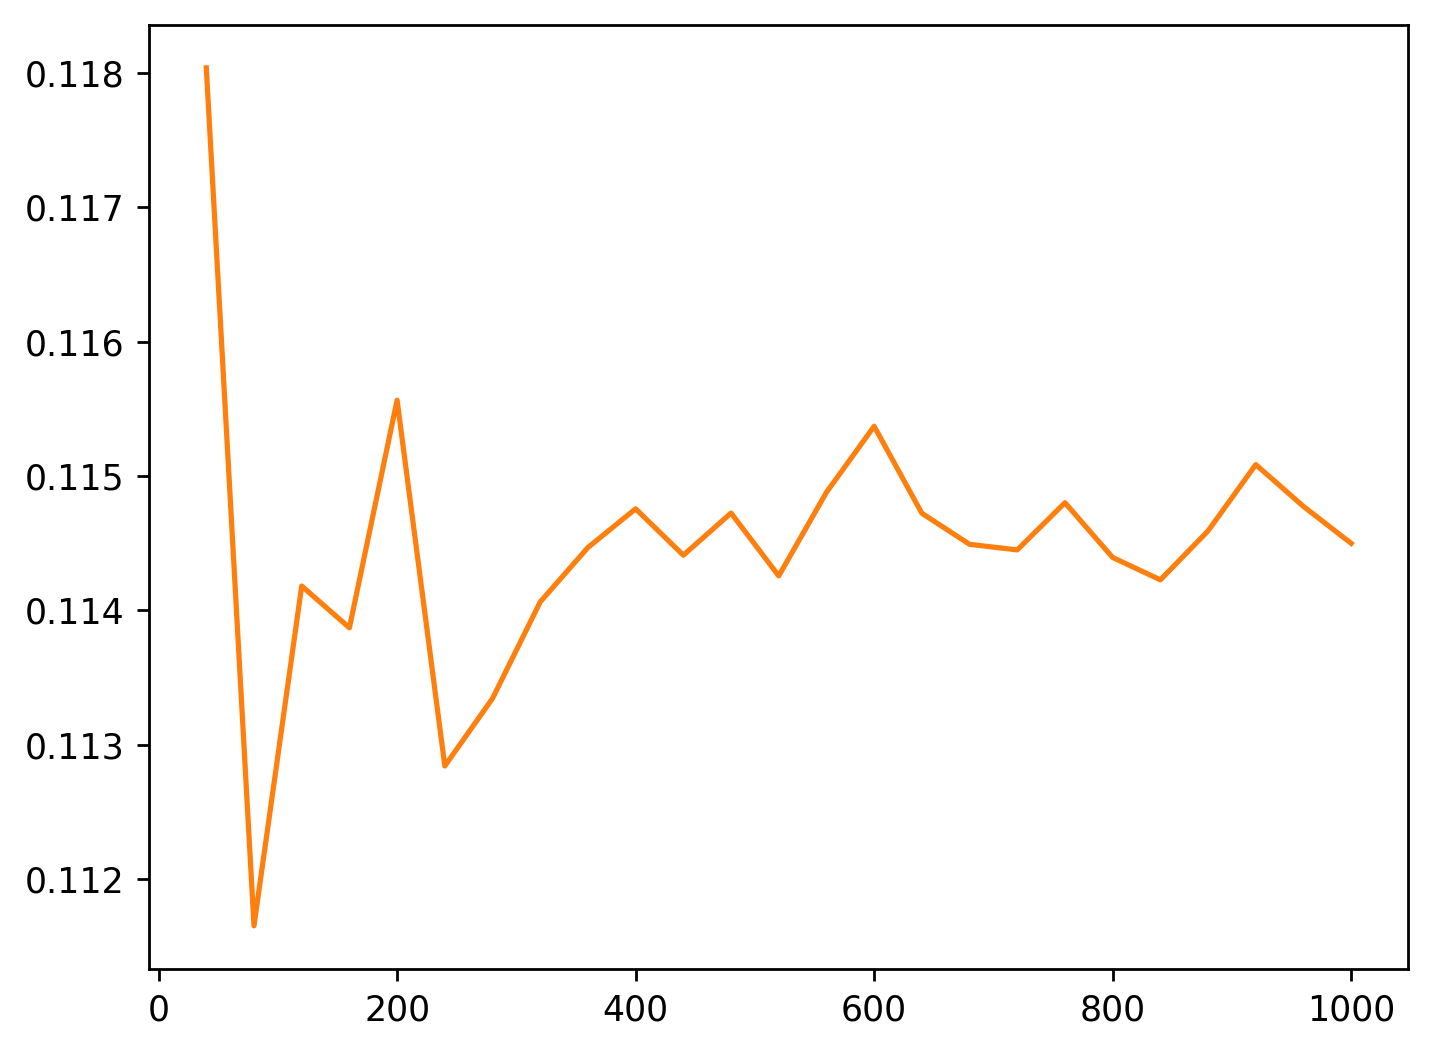

In [12]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,metric_a_RF, color='tab:orange')
plt.show()

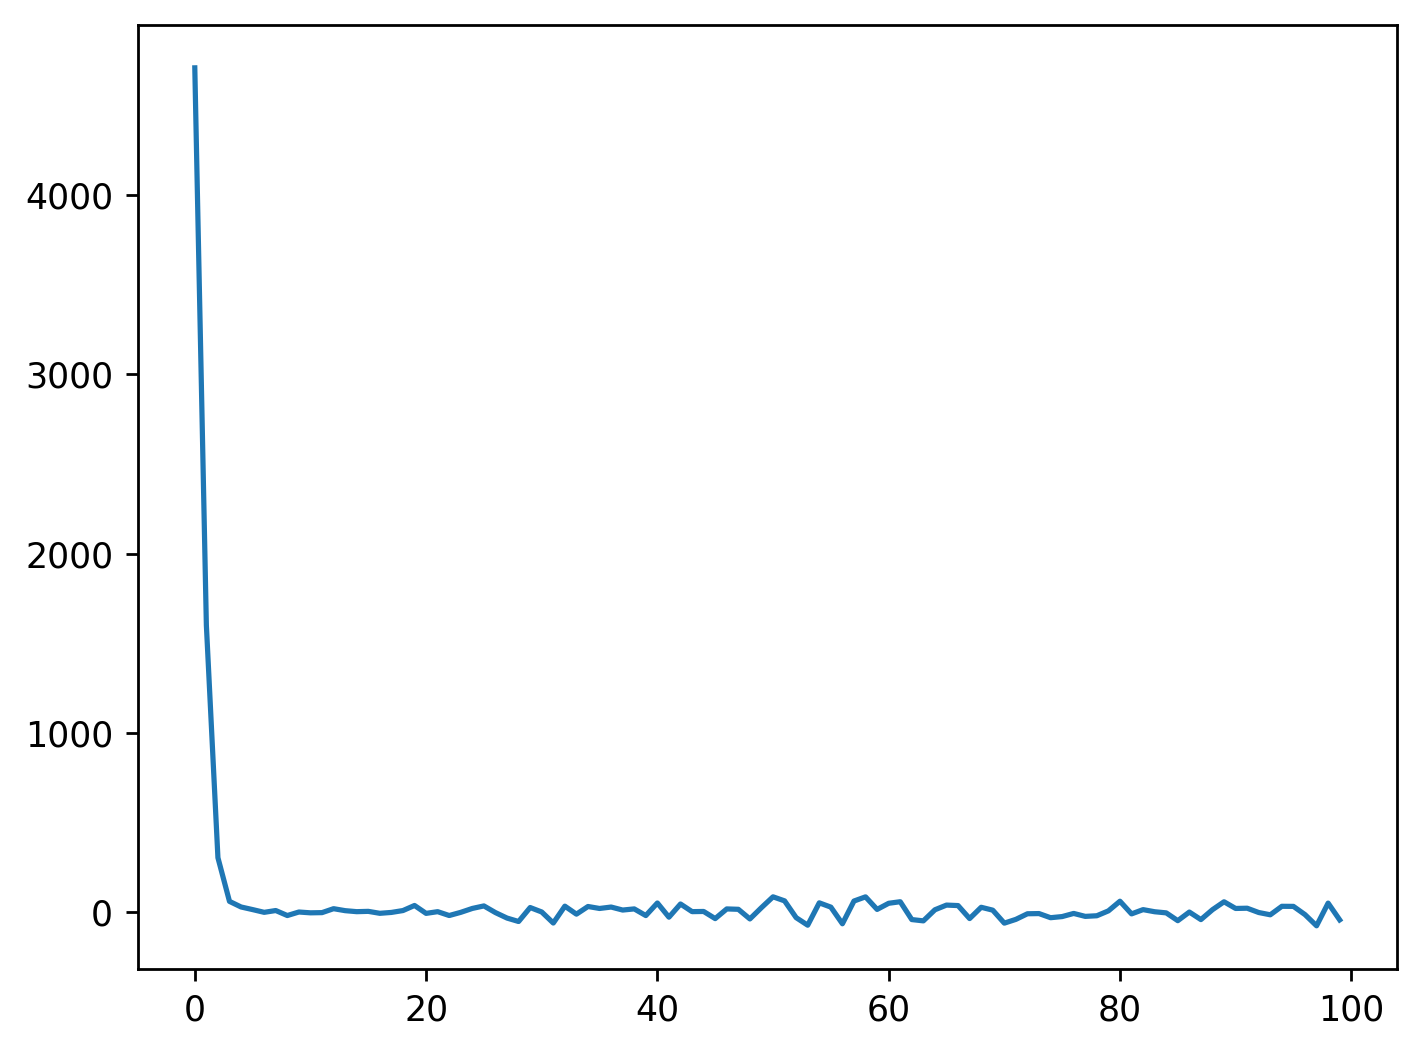

In [13]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(100),metric_b_NN, color='tab:blue')
plt.show()

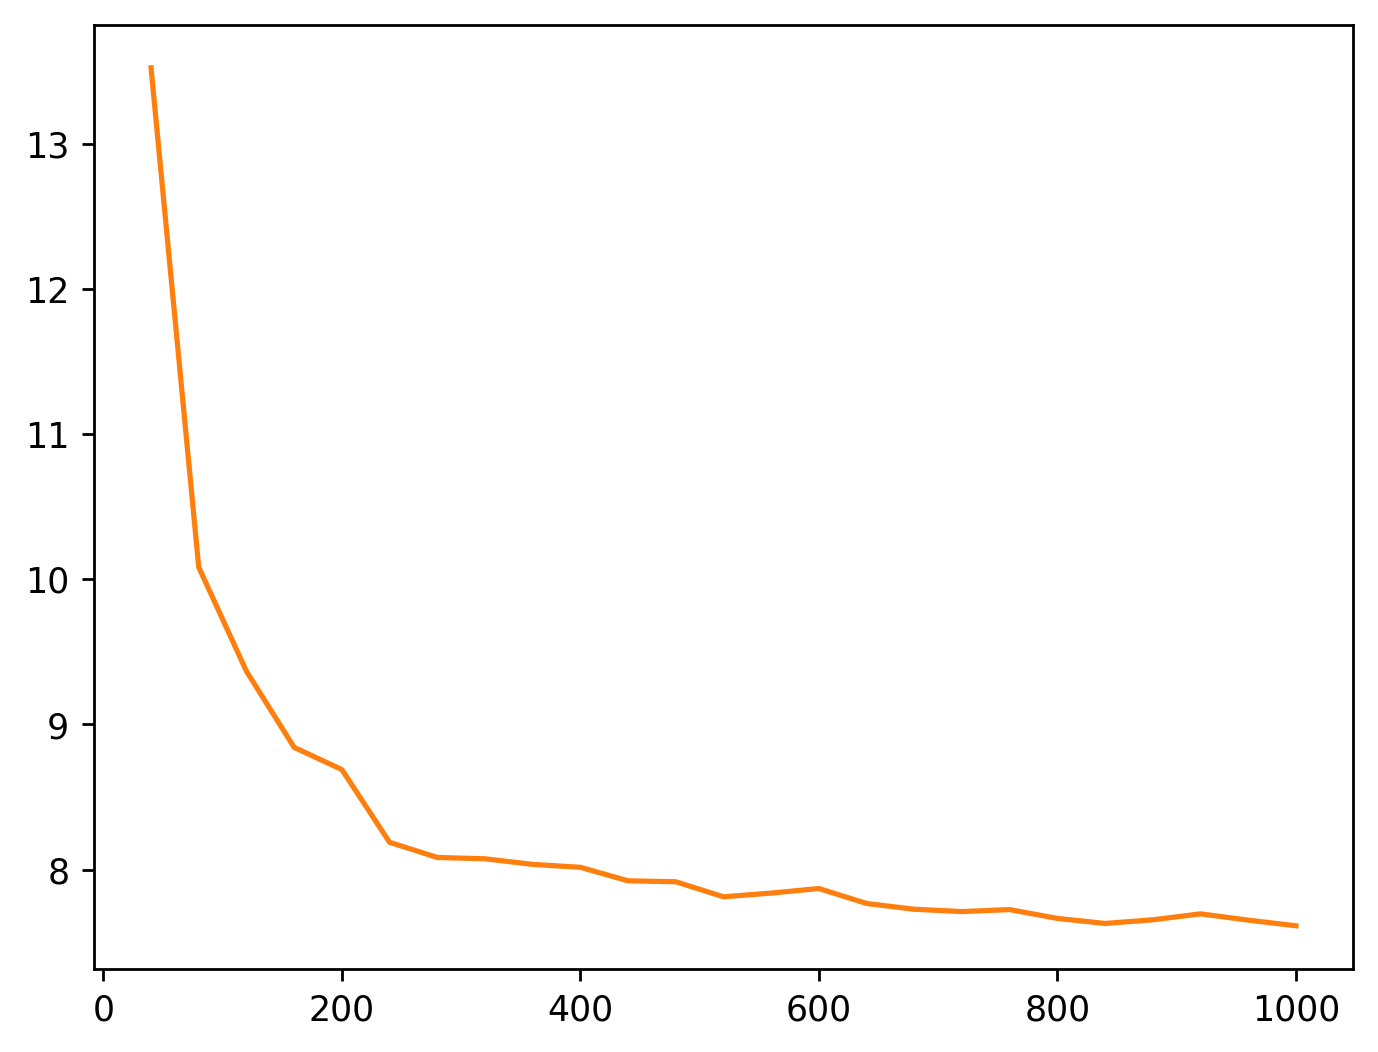

In [14]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,metric_b_RF, color='tab:orange')
plt.show()

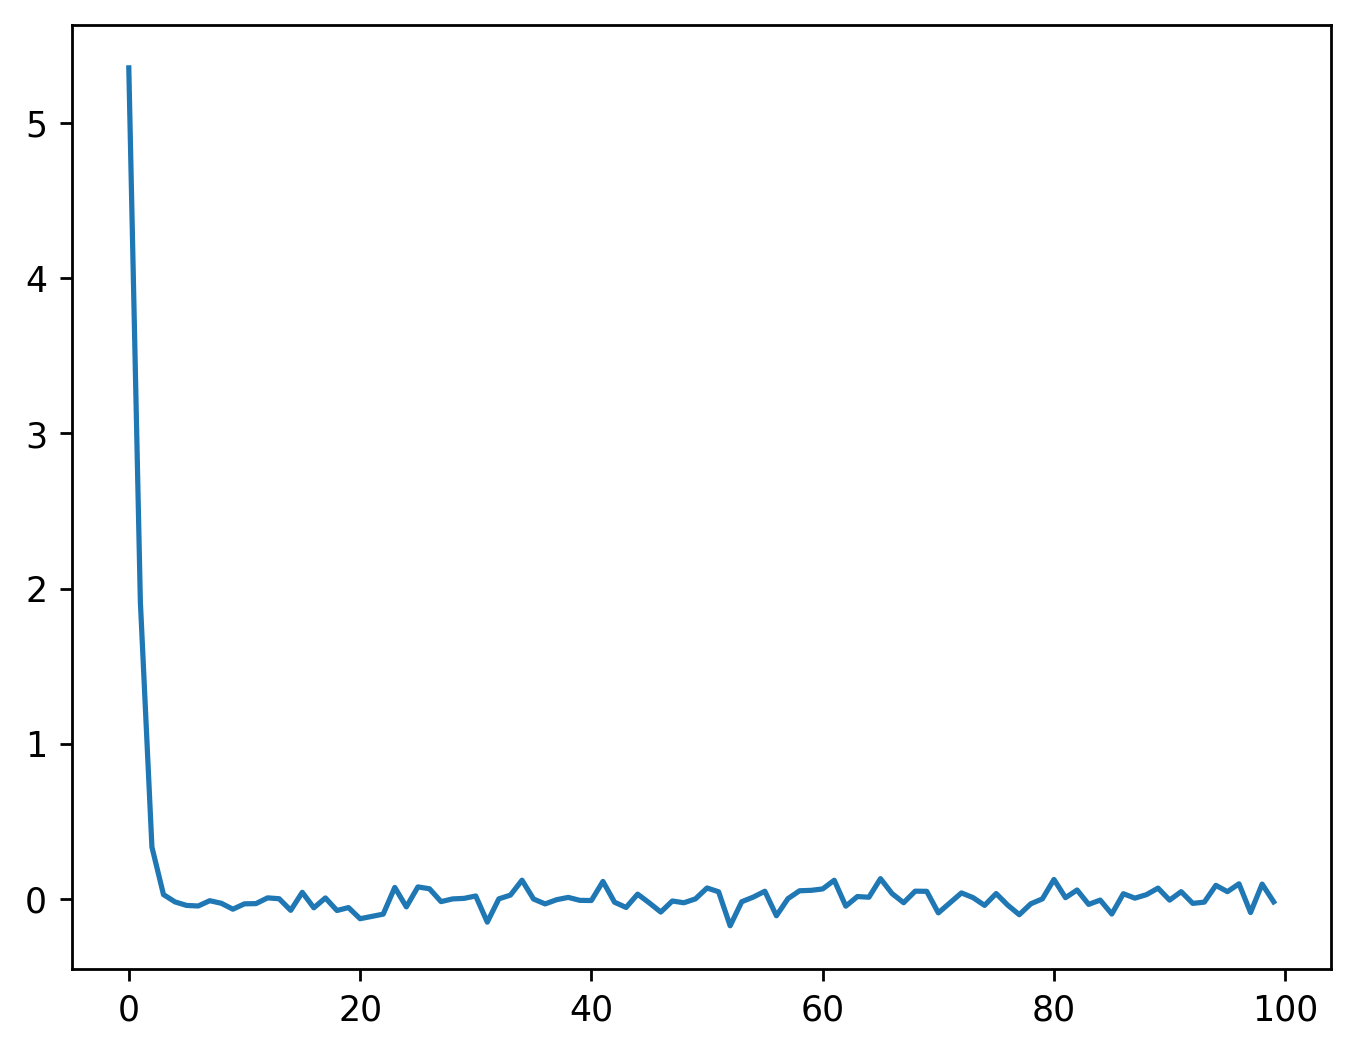

In [15]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(100),metric_c_B_1_NN, color='tab:blue')
plt.show()

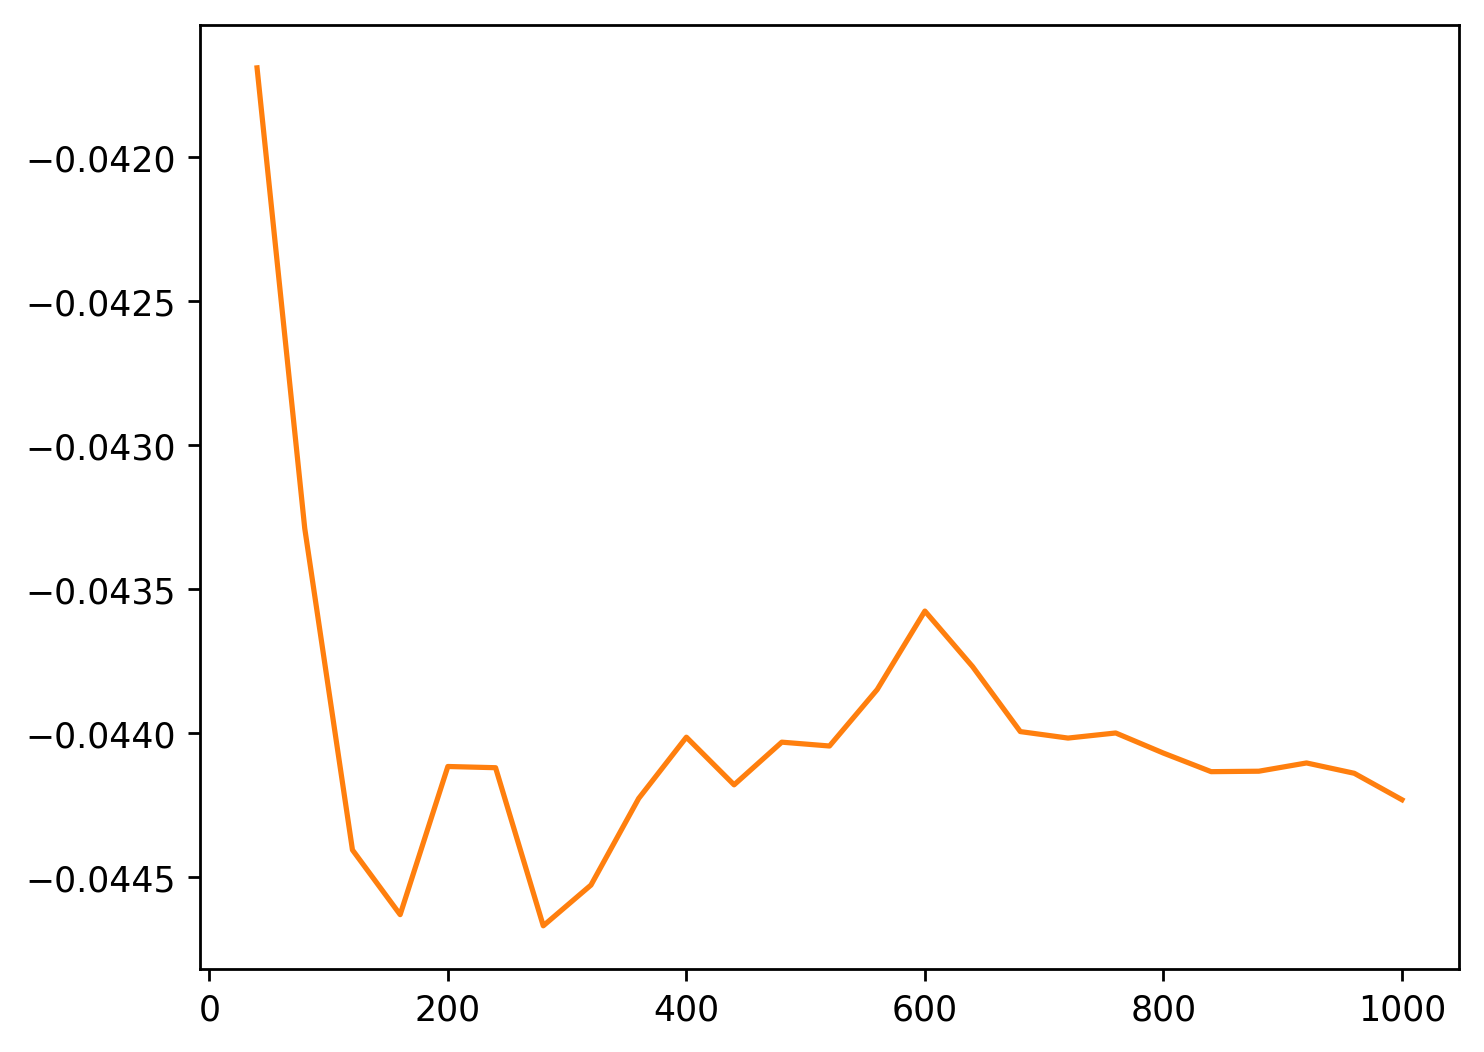

In [16]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,metric_c_B_1_RF, color='tab:orange')
plt.show()

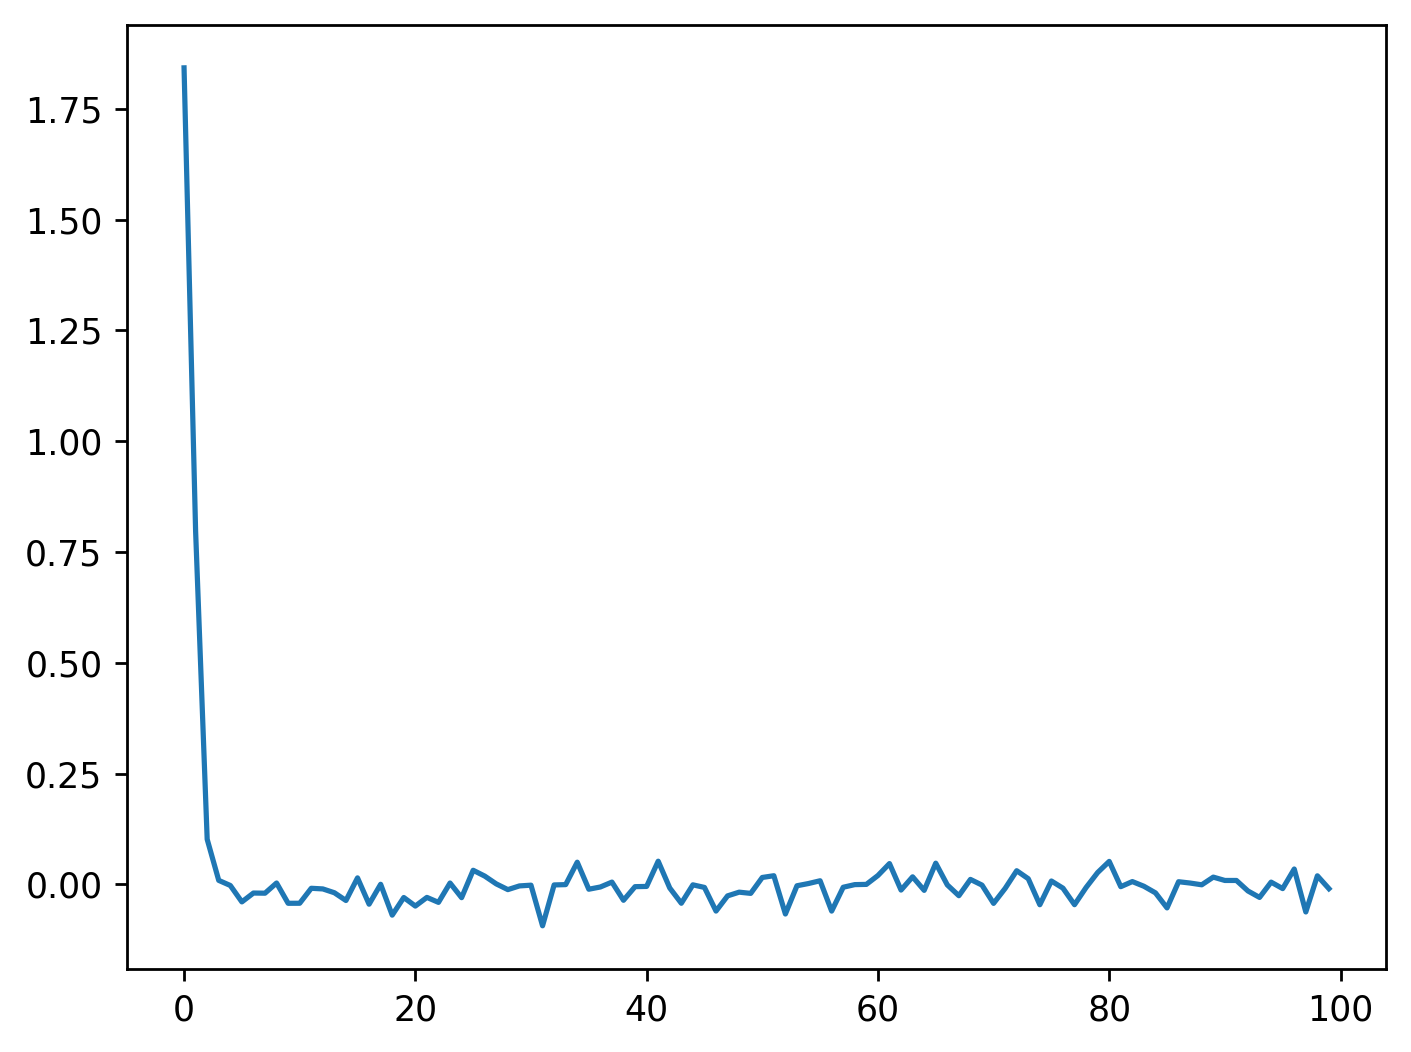

In [17]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(100),metric_c_B_2_NN, color='tab:blue')
plt.show()

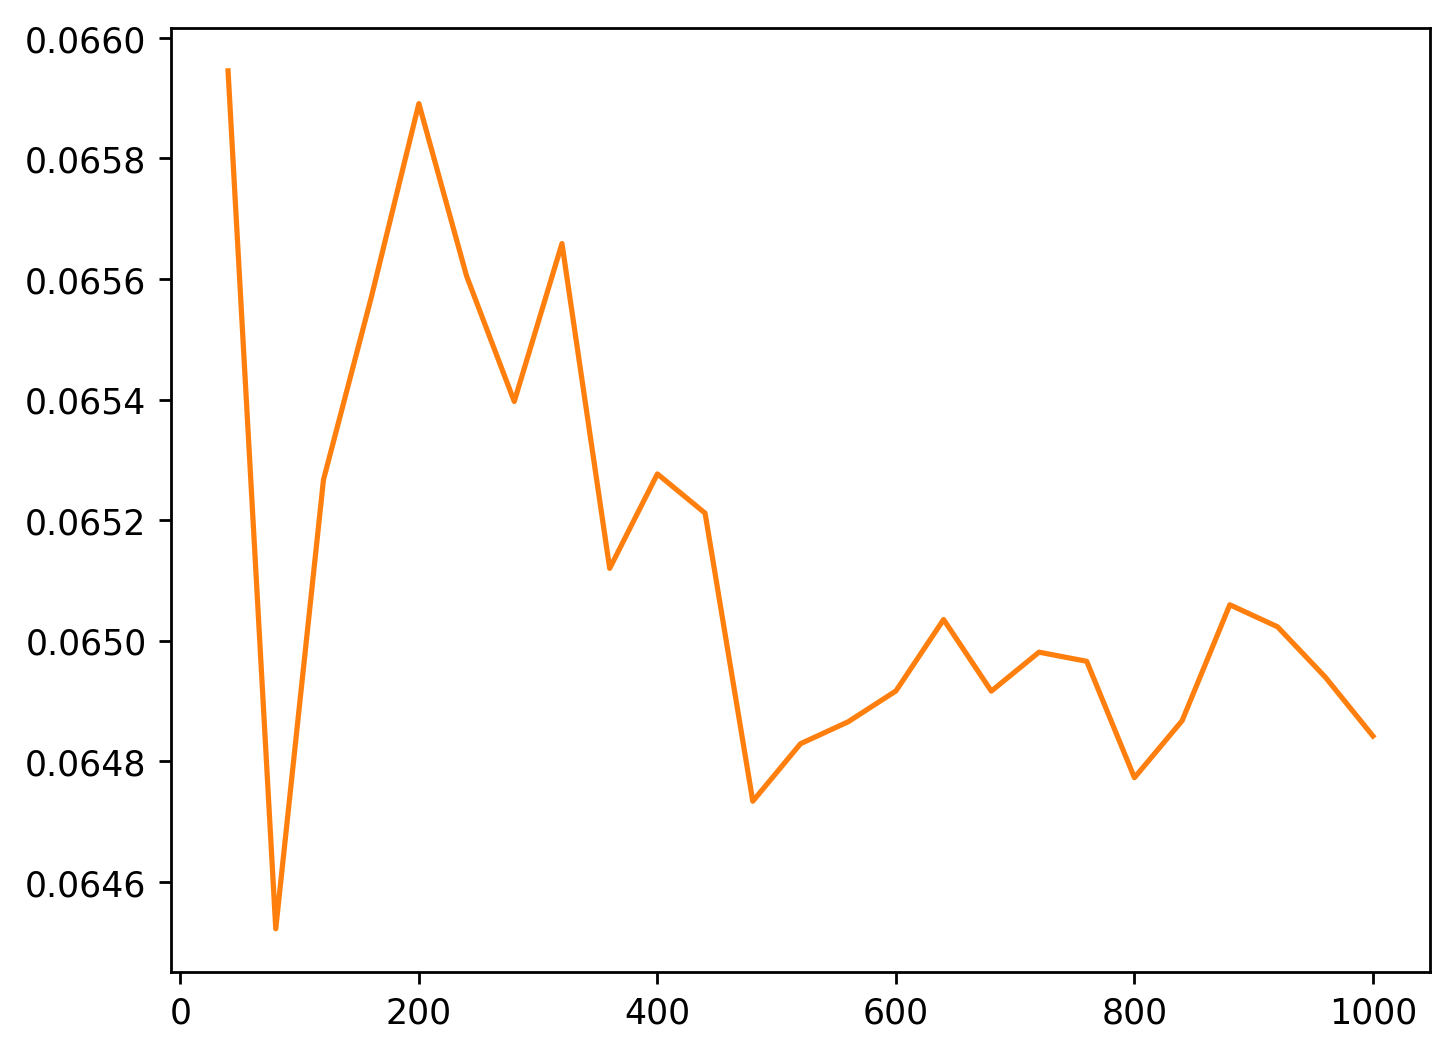

In [18]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,metric_c_B_2_RF, color='tab:orange')
plt.show()

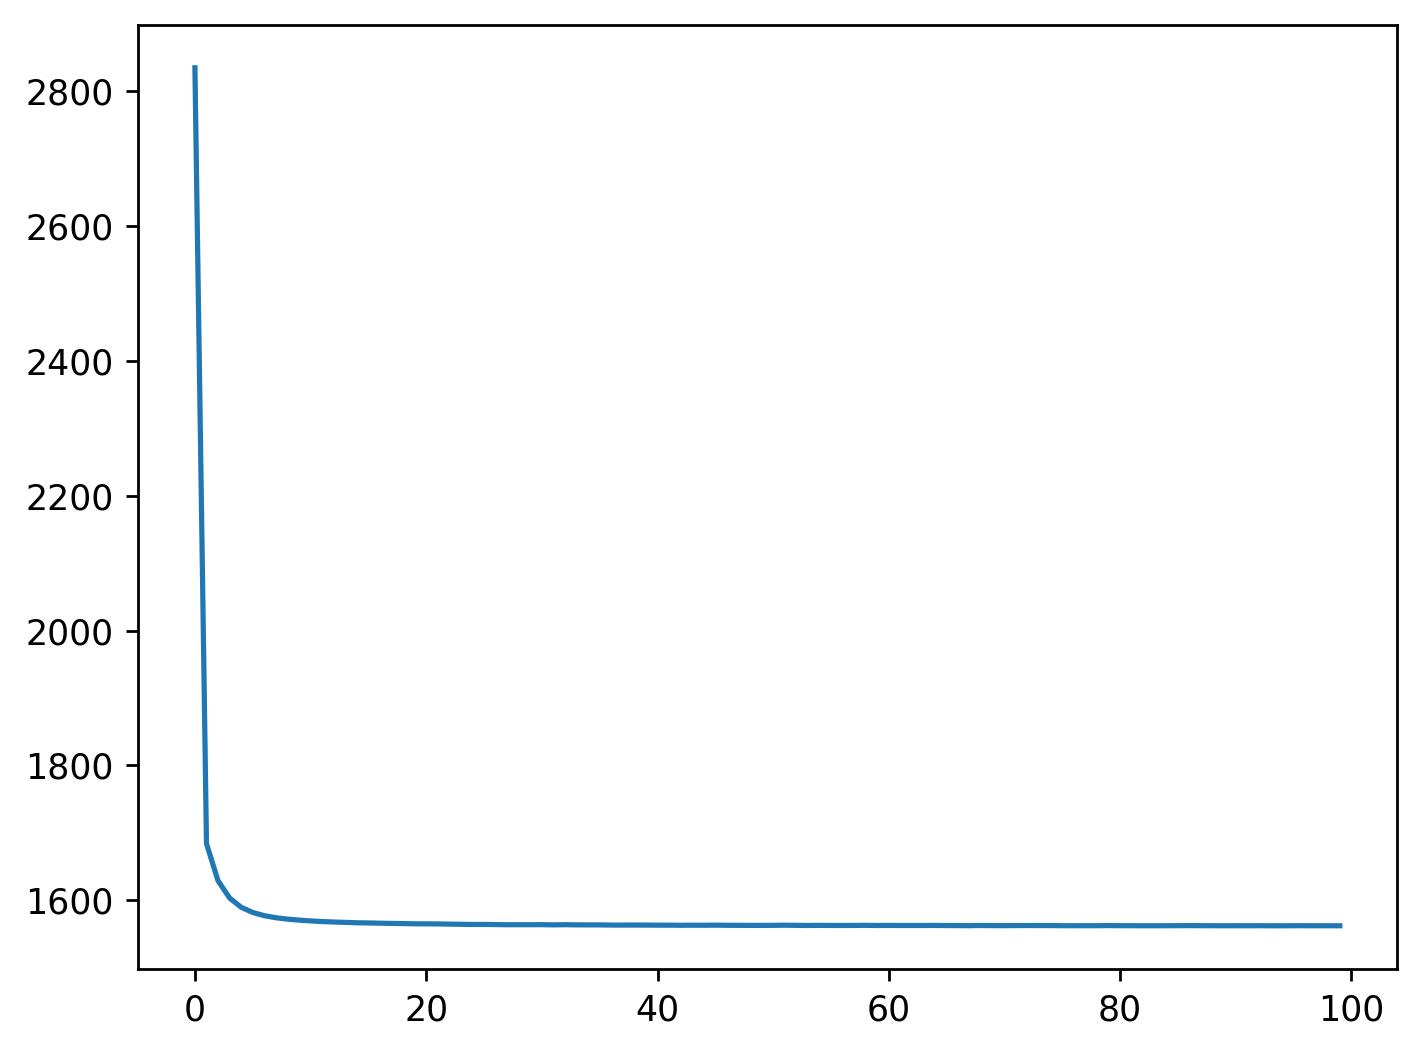

In [19]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(100),hist.history['mse'], color='tab:blue')
plt.show()

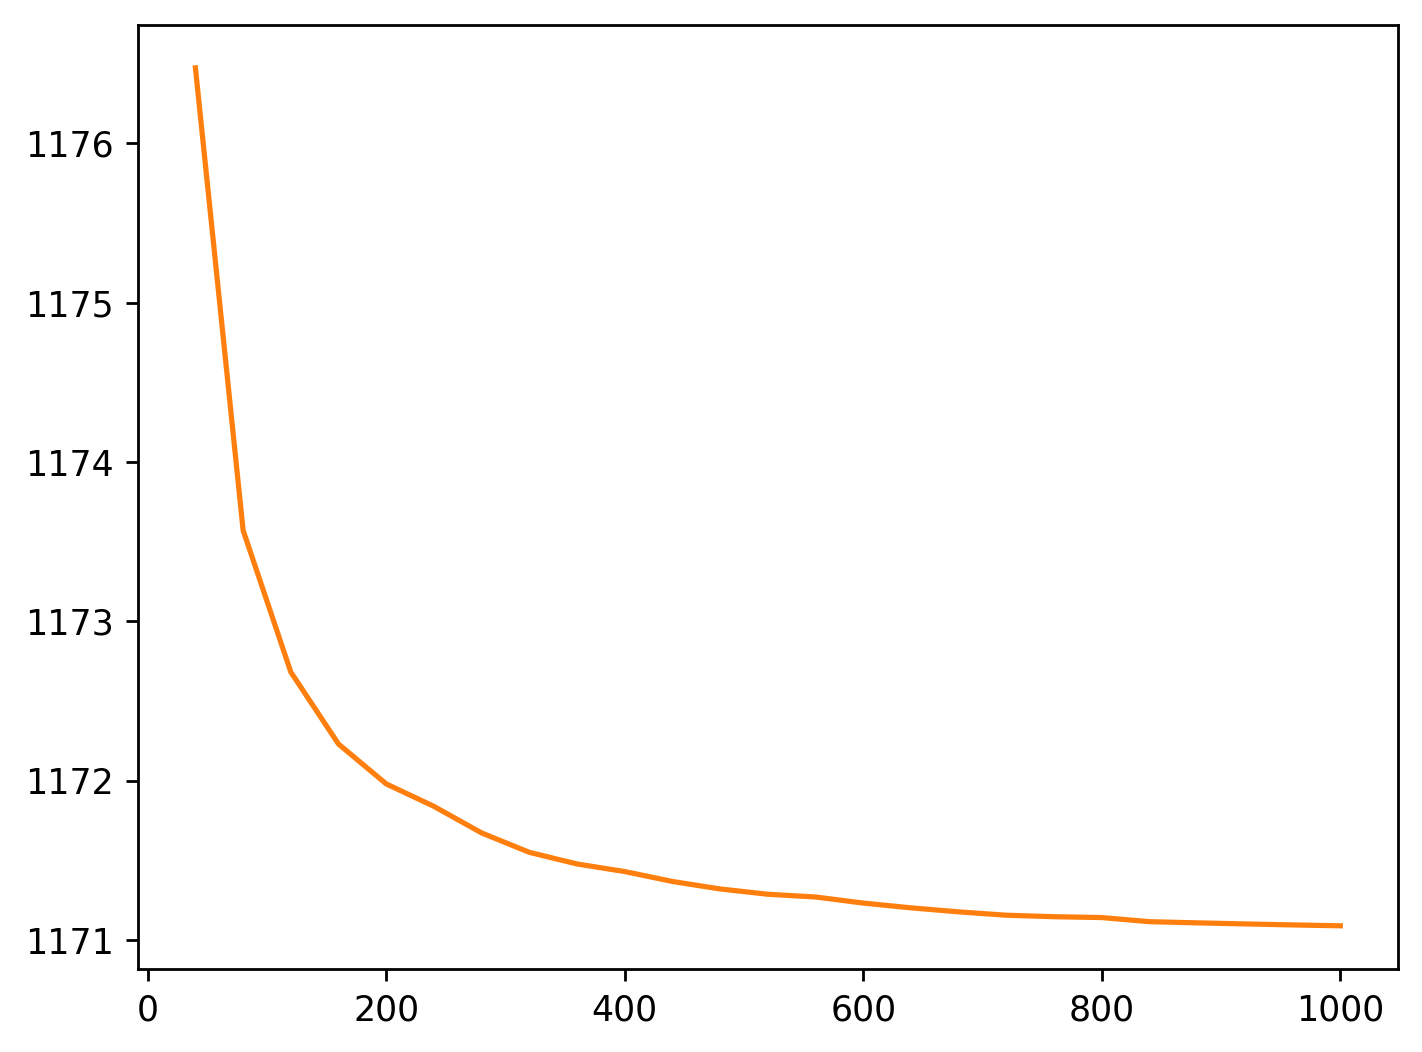

In [20]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,mse_train_RF, color='tab:orange')
plt.show()

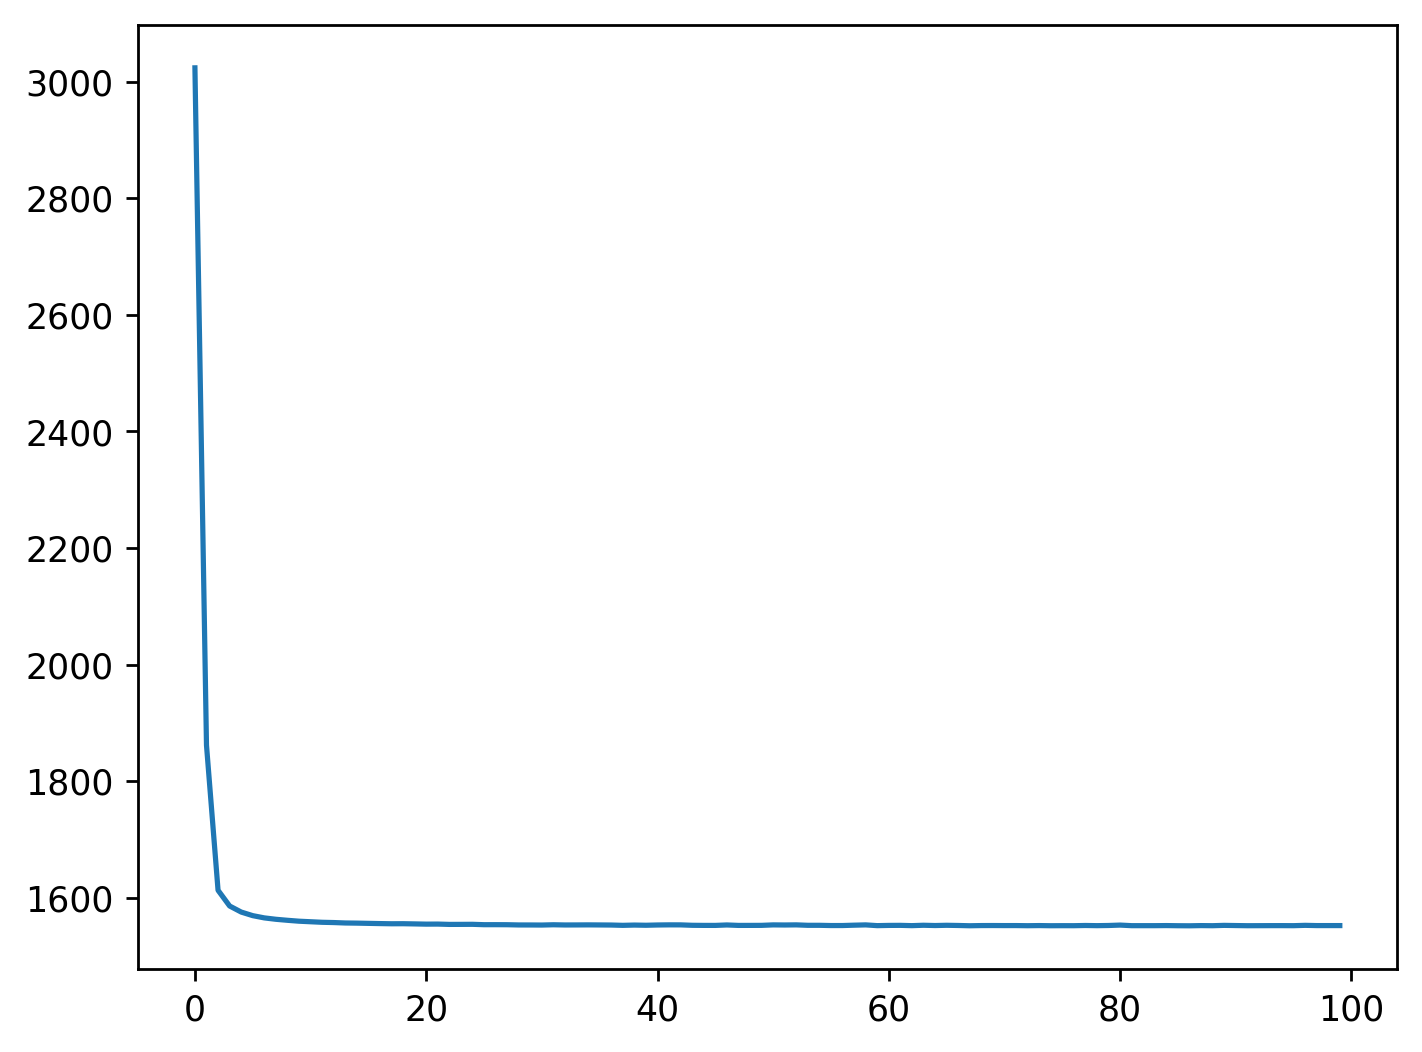

In [21]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(range(100),hist.history['val_mse'], color='tab:blue')
plt.show()

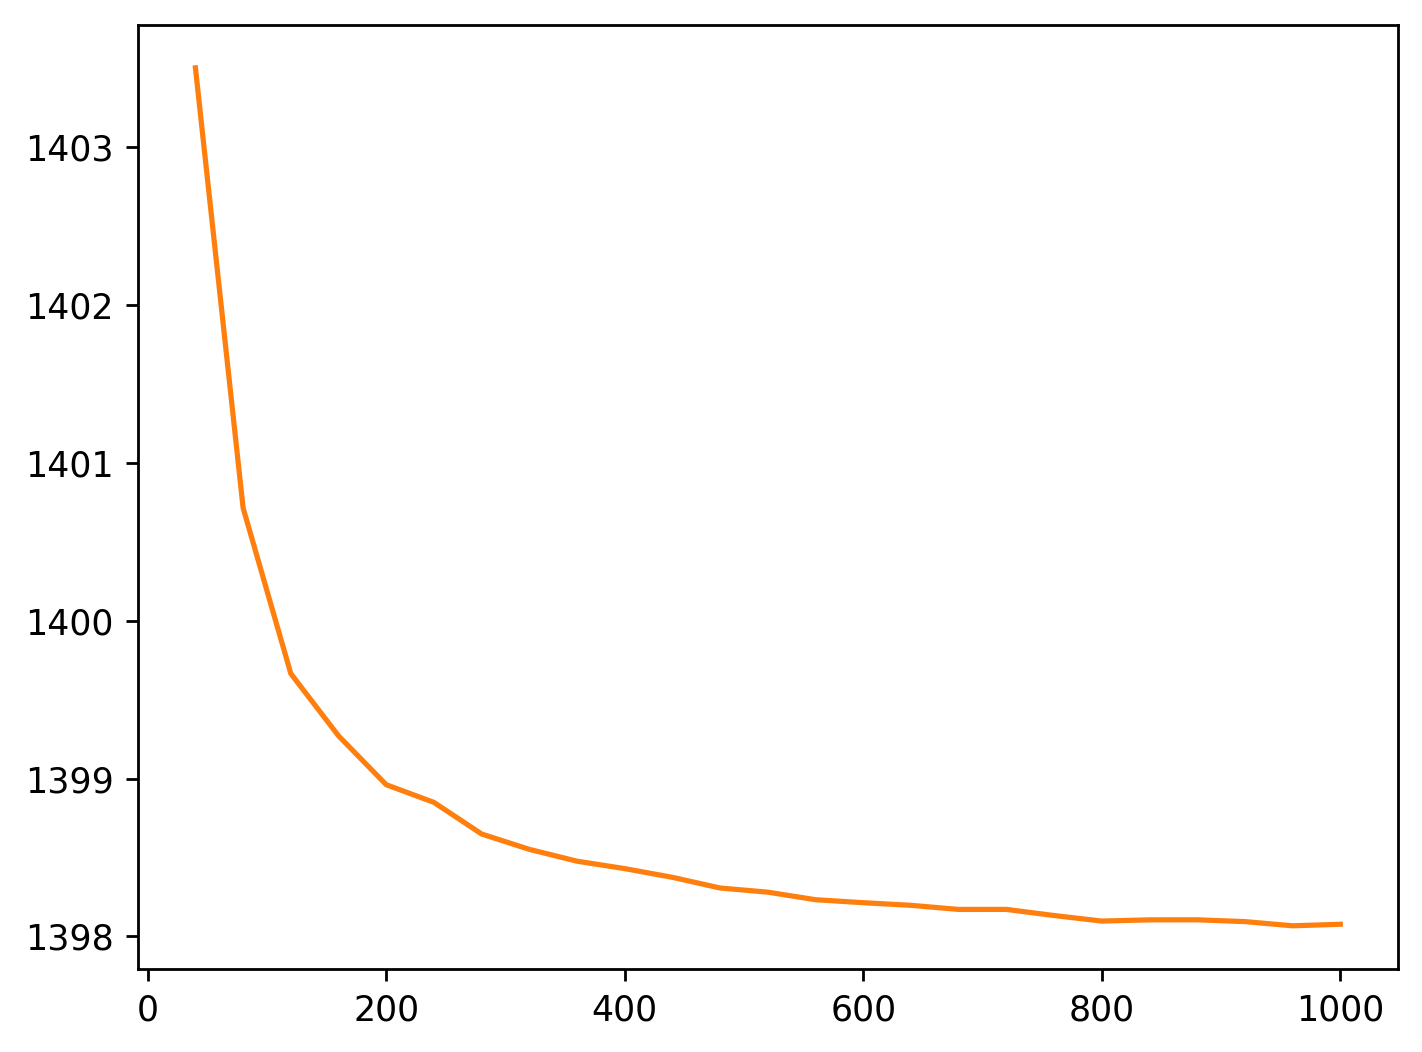

In [22]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(n_tree_steps,mse_val_RF, color='tab:orange')
plt.show()

Plots of the risk measure estimators calculated in the stepwise procedure.

In [23]:
steps = np.linspace(i, 500000, step_number)

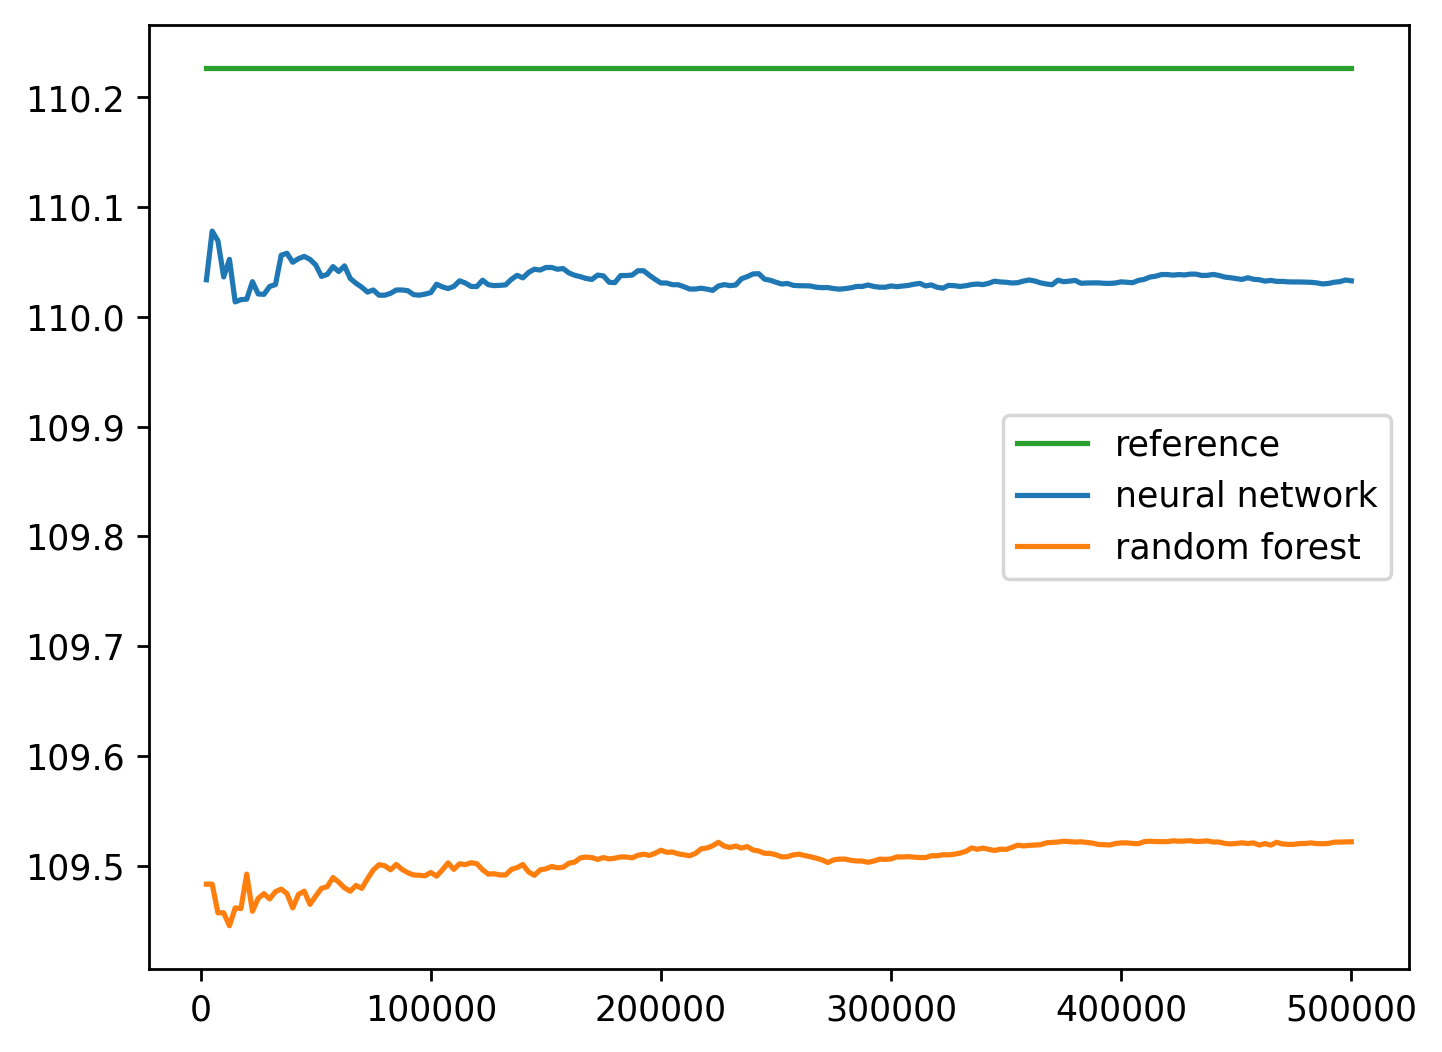

In [24]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(steps,np.full(len(steps),110.227), color='tab:green')
plt.plot(steps,VaR_hat_NN, color='tab:blue')
plt.plot(steps,VaR_hat_RF, color='tab:orange')
plt.legend(['reference', 'neural network', 'random forest'])
plt.show()

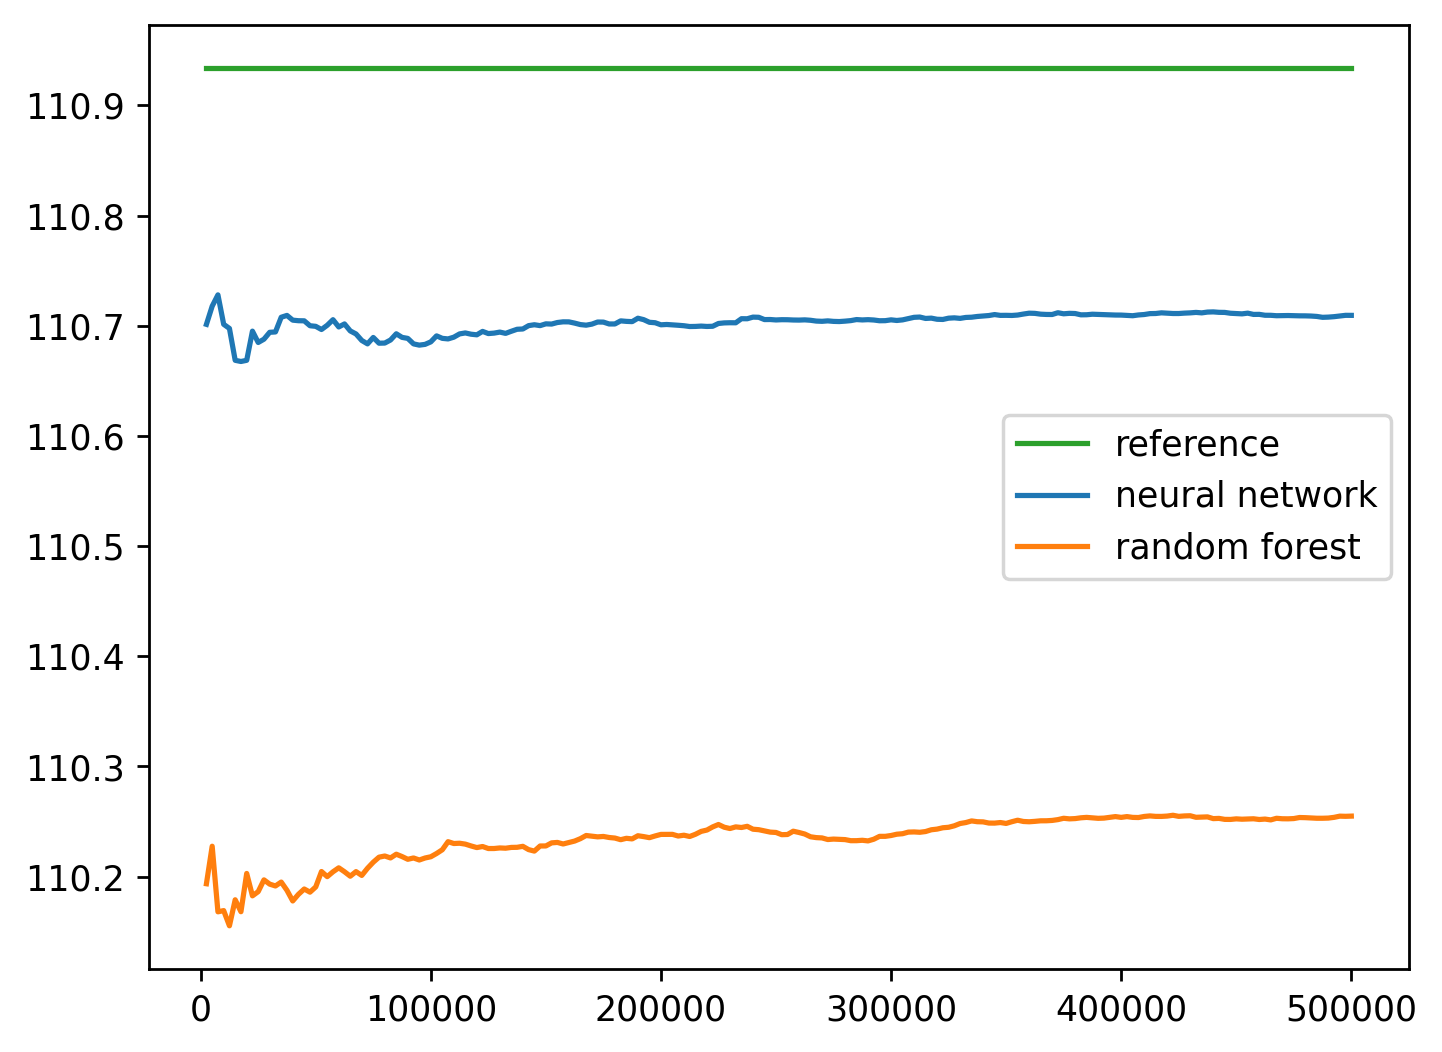

In [25]:
plt.figure(figsize=(6.5,5),dpi=250)
plt.plot(steps,np.full(len(steps),110.934), color='tab:green')
plt.plot(steps,ES_hat_NN, color='tab:blue')
plt.plot(steps,ES_hat_RF, color='tab:orange')
plt.legend(['reference', 'neural network', 'random forest'])
plt.show()

In [26]:
#Saving the computed risk measure estimators such that they can be compared to estimators produced with usage of the importance sampling procedure in another notebook (single_run_eval.ipynb)
joblib.dump(VaR_hat_NN, filepath+'VaR_hat_IS_1_NN_'+str(int(M_IS/1000))+'.joblib')
joblib.dump(VaR_hat_RF, filepath+'VaR_hat_IS_1_RF_'+str(int(M_IS/1000))+'.joblib')
joblib.dump(ES_hat_NN, filepath+'ES_hat_IS_1_NN_'+str(int(M_IS/1000))+'.joblib')
joblib.dump(ES_hat_RF, filepath+'ES_hat_IS_1_RF_'+str(int(M_IS/1000))+'.joblib')

['/pfs/data5/home/ul/ul_student/ul_ynv73/PTF/saved_mix/ES_hat_IS_1_RF_1000.joblib']